In this Notebook, we want to look at a dataset of tweets sent to six major US airlines, analyse them for any insight into issues particular to each airline, see what people are generally saying about the airlines, and finally do a Machine Learning algorithm classification of tweets as 'positive', 'negative' or 'neutral.

The dataset can be found on Kaggle at https://www.kaggle.com/crowdflower/twitter-airline-sentiment.

The head of the dataset looks like this:

In [53]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Tweets.csv", sep = ',')
df.head(4) # now head to bottom to load subsetted df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)


We have information about the tweet, the person who tweeted, the sentiment (positive, neutral, negative), the airline, the number of times the tweet was retweeted, and place and time where the tweet was created, and the timezone of the user.

This is a little too much information for what we need. We will explore each variable to see what ones are most important.

Ultimately, we are interested in the text of the tweets, the airline which the tweet was directed at, and whether this tweet was positive, negative, or neutral. 

Let's have a look first at what airlines we're dealing with.

In [49]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

And the counts of overall positive/negative/neutral tweets are as follows.

In [10]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

We have mostly negative tweets, but enough neutral and positive tweets that we should be able to build a classifier at the end of the notebook. As we are particularly interested in negative tweets, let's look at the variable negativereason.

In [13]:
df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

This gives us some information as to why the tweets were negative, later on we will look at the tweets themselves to see if we can get more information.

We should also look at the amount of missing values for each variable.

In [4]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In a dataset of about 15000 entries, some of these missing value counts are too much to be useful. On further exploring the variables such as negativereason, negativereason_confidence, airline_sentiment_gold and negativereason_gold, we find that there is no information here which we won't have in other variables, so we drop these columns.

In [14]:
df.drop(['negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold'], axis = 1, inplace = True)

The ID of the individual tweets are also not useful to us, and neither are the tweet coordinates, which have too many missing values. We drop these also. 

In [15]:
df.drop(['tweet_id', 'tweet_coord'], axis = 1, inplace = True)

The variable airline_sentiment_confidence seems to be the level of confidence which the tweets were manually labelled when the data was collected. This won't give us much information for this particular analysis, so we can remove this variable.

In [17]:
df.drop('airline_sentiment_confidence', axis = 1, inplace = True)

Now we have the dataset in a form where we can begin to explore the tweets and tweeters themselves a little better. First let's begin by looking at the Twitter accounts - do we have any trolls or other spam accounts, which might mislead us? Let's look at the accounts which have the most tweets in our dataset.

In [24]:
tweeters = df['name'].value_counts()
tweeters[tweeters > 15]

JetBlueNews        63
kbosspotter        32
_mhertz            29
otisday            28
throthra           27
rossj987           23
weezerandburnie    23
MeeestarCoke       22
GREATNESSEOA       22
scoobydoo9749      21
jasemccarty        20
georgetietjen      19
ElmiraBudMan       19
flemmingerin       19
chagaga2013        18
thomashoward88     18
ThatJasonEaton     18
Aero0729           18
worldwideweg       17
SMHillman          17
heyheyman          16
arthurhasher       16
patrick_maness     16
Name: name, dtype: int64

We don't have any accounts with crazy amounts of tweets. We can check some of these tweets at random from the accounts above, to see if they are real people, or spam/competitions/etc.

In [28]:
print(df[df['name'] == '_mhertz']['text'].iloc[3])
print()
print(df[df['name'] == 'flemmingerin']['text'].iloc[1])
print()
print(df[df['name'] == 'ThatJasonEaton']['text'].iloc[3])
print()
print(df[df['name'] == 'patrick_maness']['text'].iloc[14])
print()
print(df[df['name'] == 'JetBlueNews']['text'].iloc[5])

@united you're the reason this whole travel experience has been a nightmare

@AmericanAir thanks for following up- it finally worked!! Fingers crossed the new flight works.

@JetBlue This is absurd. Should a stranger help my kids if there's a problem? #jetblue http://t.co/LAiGgef9Kj

@united I would have made it if you hadn't already booked me on another flight and Cancelled Flighted my original reservation.

@JetBlue Airways Lowered to Strong Sell at Vetr Inc. (JBLU) - Mideast Time http://t.co/yMMH9k4CBr


Generally, it seems that these are real people, apart from JetBlueNews, which seems to be some news account for one of the airlines. At any rate, these accounts aren't particularly spammy or trolling, so we don't need to worry about their tweets throwing off our analysis too much. 

Next let's have a look at the timestamps of the tweets being sent, to see if we can learn anything there.

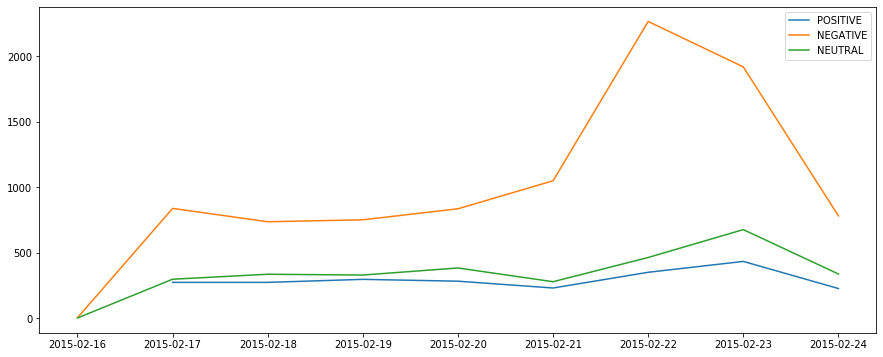

In [54]:
tweet_sent = df[['airline_sentiment', 'airline', 'tweet_created']] # subset df

pos_times = pd.to_datetime(tweet_sent[tweet_sent['airline_sentiment'] == 'positive']['tweet_created']) # positive as datetime
neg_times = pd.to_datetime(tweet_sent[tweet_sent['airline_sentiment'] == 'negative']['tweet_created']) # negative as datetime
neut_times = pd.to_datetime(tweet_sent[tweet_sent['airline_sentiment'] == 'neutral']['tweet_created']) # neutral as datetime

pos_times = pos_times.apply( lambda x : x.date() ) # extract daily
neg_times = neg_times.apply( lambda x : x.date() )
neut_times= neut_times.apply( lambda x : x.date() )

pos_times = pd.DataFrame(pos_times.value_counts()) # value counts per day
neg_times = pd.DataFrame(neg_times.value_counts())
neut_times = pd.DataFrame(neut_times.value_counts())

pos_times.columns = ['POSITIVE']
neg_times.columns = ['NEGATIVE']
neut_times.columns = ['NEUTRAL']

times = pd.concat([pos_times, neg_times, neut_times], axis = 1)

times.plot(figsize = (15,6));

We see that positive and neutral tweets stay fairly stationary, but there is a huge increase in negative tweets around 21st February. Let's explore negative tweets based on airline to see what is happening here.

In [56]:
neg_per_airline = tweet_sent[tweet_sent['airline_sentiment'] == 'negative']

In [57]:
neg_per_airline['tweet_created'] = pd.to_datetime(neg_per_airline['tweet_created']).apply(lambda x: x.date())
# times to datetime daily

United = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'United']['tweet_created'].value_counts())
United.columns = ['United']

US_Airways = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'US Airways']['tweet_created'].value_counts())
US_Airways.columns = ['US_Airways']

American = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'American']['tweet_created'].value_counts())
American.columns = ['American']

Southwest = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'Southwest']['tweet_created'].value_counts())
Southwest.columns = ['Southwest']

Delta = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'Delta']['tweet_created'].value_counts())
Delta.columns = ['Delta']

Virgin_America = pd.DataFrame(neg_per_airline[neg_per_airline['airline'] == 'Virgin America']['tweet_created'].value_counts())
Virgin_America.columns = ['Virgin_America']

Negative_airline = pd.concat([United, US_Airways, American, Southwest, Delta, Virgin_America], axis = 1)
Negative_airline.fillna(0, inplace = True)
Negative_airline

,United,US_Airways,American,Southwest,Delta,Virgin_America
2015-02-22,532,561.0,762.0,129.0,255,27.0
2015-02-23,449,372.0,826.0,116.0,125,31.0
2015-02-21,365,291.0,1.0,257.0,98,37.0
2015-02-20,342,248.0,1.0,132.0,91,21.0
2015-02-19,272,193.0,0.0,127.0,135,24.0
2015-02-17,272,233.0,0.0,213.0,108,12.0
2015-02-18,257,244.0,1.0,110.0,105,19.0
2015-02-24,142,121.0,369.0,102.0,37,10.0
2015-02-16,2,0.0,0.0,0.0,1,0.0


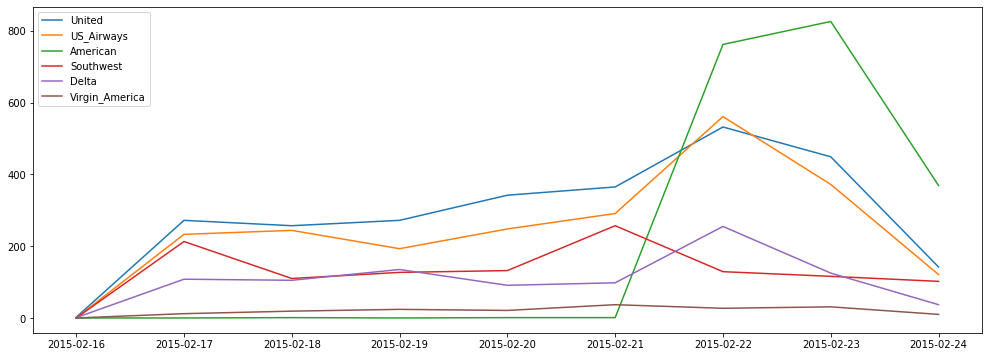

In [78]:
Negative_airline.plot(figsize = (17,6));

Although negative trends for a few airlines seem to be slowly trending upwards, there is a huge spike in negative tweets for American Airlines from 21st February. This spike corresponds to the increase in negative tweets seen in the plot above for all negative tweets. Let's explore what happened around this date by looking at the tweets to American Airlines from 21st February.


In [132]:
AA_tweets = df[ (df['airline_sentiment'] == 'negative') & (df['airline'] == 'American') ][['airline', 'tweet_created','text']]
AA_tweets['tweet_created'] = pd.to_datetime(AA_tweets['tweet_created'])

after_date = '2015-02-21'
neg_spike = (AA_tweets['tweet_created'] > after_date)

There are 1960 total negative tweets to American Airlines on or after 21st February. Reading through them, we see no singular topic to explain the uptake in negative tweets after 21st February. Below is a random sample of 25 tweets sent after 21/02.

In [131]:
sample = np.random.randint(0,1960,25)
after_21_02 = AA_tweets.loc[neg_spike].sort_values('tweet_created', ascending = True)

for i in sample:
    print(after_21_02.iloc[i]['text'])
    print()

@AmericanAir Nice AA employee making skillful excuses about Late Flightness due to catering snafu... http://t.co/YPVPVdlTYs

@AmericanAir living in DFW.. Your Hub.. Hate having to fly to JFK to get to Ireland

@AmericanAir sorry so Late Flight, responded to your DM.

@AmericanAir I did set up notifications through AA &amp; Us airways. still nothing

@AmericanAir the customer service today is unsat, Flight cnx, not notified, called for 6 hours and the phone line does not even let me hold

@AmericanAir Can't get thru by phone to use a credit that's about to expire! #frustrated #aa.com

@AmericanAir You Cancelled Flight my flight and there’s no way to rebook on the website or app? I have to wait 35 minutes on hold? #fail cc @Delta

@AmericanAir VERY upset that I cannot select seats for Tuesday flight online or over the phone. Terrible customer service :( Please help!

@AmericanAir Flight #2390 delayed 14 hours!! No one at #AmericanAirlines counter can tell my husband that he will be on th

It's curious that there is such a sharp uptake in negative tweets with no single incident. A Google search returns no major reason, but if we look at the tweets before 21/02 to American, we see that there must have been some mistake in scraping the data, as there are only two tweets. A Twitter search shows that AA has had their account since 2009, so we conclude that this spike was just due to a mistake in collecting the data. Crisis averted for American Airlines.

In [133]:
before_neg_spike = (AA_tweets['tweet_created'] <= after_date)
AA_tweets.loc[before_neg_spike]

,airline,tweet_created,text
12035,American,2015-02-20 09:28:32-08:00,"@AmericanAir - how long does it take to get credit to my AA account? Traveled in Jan &amp; only one leg reported. Asked for credit, no response."
12037,American,2015-02-18 20:25:30-08:00,"@AmericanAir Okay, I think 1565 has waited long enough for a gate at DFW..."


Next we'll look at the locations recorded in the dataset. We're missing 4733 location inputs, which is a third of the dataset. Still, we should check out what kind of locations are tweeters are in.

In [3]:
df['tweet_location'].isnull().sum()

4733

Let's check out what locations crop up most often. New York, Boston, Chicago, Washington D.C. and San Francisco seem to pop up the most. We also have Los Angeles, Dallas and Austin. We might have either quite a few business travellers or political employees travelling, with these locations, or at least a lot of tweets from people travelling to these destinations.

In [5]:
tweet_locations = df['tweet_location'].value_counts()
list(pd.DataFrame(tweet_locations[tweet_locations > 50]).reset_index()['index'])

['Boston, MA',
 'New York, NY',
 'Washington, DC',
 'New York',
 'USA',
 'Chicago',
 'New York City',
 'Los Angeles, CA',
 'NYC',
 'San Francisco, CA',
 'San Francisco',
 'Chicago, IL',
 'Brooklyn, NY',
 'Los Angeles',
 'Austin, TX',
 'Washington, D.C.',
 'Boston',
 'Dallas, TX',
 'Washington DC']

Let's see if these cities also crop up when we just look at negative tweets. 

In [7]:
neg_tweets = df[df['airline_sentiment'] == 'negative']
neg_tweet_locations = neg_tweets['tweet_location'].value_counts()
list(pd.DataFrame(neg_tweet_locations[neg_tweet_locations > 40]).reset_index()['index'])

['Washington, DC',
 'Boston, MA',
 'New York, NY',
 'New York',
 'Chicago',
 'NYC',
 'San Francisco, CA',
 'Los Angeles, CA',
 'New York City',
 'San Francisco',
 'Chicago, IL',
 'Brooklyn, NY',
 'Austin, TX',
 'Washington, D.C.',
 'Washington DC']

We see that the cities are mostly the same. We could conclude that in order to improve customer sentiment, more services could be put in place for flights to these cities. However, a much more detailed analysis on airline, flight number, actual text of tweets would be necessary before any real changes should be made with confidence. 

Now let's get an idea of what the tweeters are saying the most in their negative tweets. Hashtags are a very common method of succintly conveying an idea, so we will do a quick analysis for the most common hashtags in all the negative tweets, split by airline.

First, we will write a function to extract the hashtags, then place them in a list, then rank that list based on how often the hashtag appears. Finally, we will do a simple WordCloud for illustration purposes. An example is given below.

In [9]:
neg_uni = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'United')]['text'] # negative tweets per airline
neg_us = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'US Airways')]['text']
neg_amer = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'American')]['text']
neg_south = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'Southwest')]['text']
neg_del = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'Delta')]['text']
neg_vir = df[ ( df['airline_sentiment'] == 'negative' ) & ( df['airline'] == 'Virgin America')]['text']

In [10]:
import re

In [12]:
### United Airlines

neg_uni_hashtags = [] # empty list

for i in np.arange(0, len(neg_uni)):
    if re.findall(r'#+[\w]+', neg_uni.iloc[i]): # if find # + alphanumeric term
         neg_uni_hashtags.append(re.findall(r'#+[\w]+', neg_uni.iloc[i])) # append # + alphanumeric to list neg_uni_hashtags
            
neg_uni_hashtags[:5]

[['#united'],
 ['#tiredofwaiting'],
 ['#Platinum', '#spoiled'],
 ['#Newarkliberty', '#Flyingainteasy'],
 ['#badcustomerservice']]

In [15]:
#### American Airlines

neg_amer_hashtags = []
for i in np.arange(0, len(neg_amer)):
    if re.findall(r'#+[\w]+', neg_amer.iloc[i]):
         neg_amer_hashtags.append(re.findall(r'#+[\w]+', neg_amer.iloc[i]))

            
#### US Airlines

neg_us_hashtags = []
for i in np.arange(0, len(neg_us)):
    if re.findall(r'#+[\w]+', neg_us.iloc[i]):
         neg_us_hashtags.append(re.findall(r'#+[\w]+', neg_us.iloc[i]))
            

#### Southwest

neg_south_hashtags = []
for i in np.arange(0, len(neg_south)):
    if re.findall(r'#+[\w]+', neg_south.iloc[i]):
         neg_south_hashtags.append(re.findall(r'#+[\w]+', neg_south.iloc[i]))
        

#### Delta

neg_del_hashtags = []
for i in np.arange(0, len(neg_del)):
    if re.findall(r'#+[\w]+', neg_del.iloc[i]):
         neg_del_hashtags.append(re.findall(r'#+[\w]+', neg_del.iloc[i]))    
            

#### Virgin

neg_vir_hashtags = []
for i in np.arange(0, len(neg_vir)):
    if re.findall(r'#+[\w]+', neg_vir.iloc[i]):
         neg_vir_hashtags.append(re.findall(r'#+[\w]+', neg_vir.iloc[i]))

In [16]:
# now make string out of all hashtags, then split on '#' symbol

# United
neg_uni_string = ' '
for i in range(0, len(neg_uni_hashtags)):
    for j in range(0, len(neg_uni_hashtags[i])):
        neg_uni_string += neg_uni_hashtags[i][j]
neg_uni_string = neg_uni_string.split('#')        

# US
neg_us_string = ' '
for i in range(0, len(neg_us_hashtags)):
    for j in range(0, len(neg_us_hashtags[i])):
        neg_us_string += neg_us_hashtags[i][j]
neg_us_string = neg_us_string.split('#')        

# American
neg_amer_string = ' '
for i in range(0, len(neg_amer_hashtags)):
    for j in range(0, len(neg_amer_hashtags[i])):
        neg_amer_string += neg_amer_hashtags[i][j]
neg_amer_string = neg_amer_string.split('#')        

# Southwest
neg_south_string = ' '
for i in range(0, len(neg_south_hashtags)):
    for j in range(0, len(neg_south_hashtags[i])):
        neg_south_string += neg_south_hashtags[i][j]
neg_south_string = neg_south_string.split('#')      

# Delta
neg_del_string = ' '
for i in range(0, len(neg_del_hashtags)):
    for j in range(0, len(neg_del_hashtags[i])):
        neg_del_string += neg_del_hashtags[i][j]        
neg_del_string = neg_del_string.split('#')      

# Virgin
neg_vir_string = ' '
for i in range(0, len(neg_vir_hashtags)):
    for j in range(0, len(neg_vir_hashtags[i])):
        neg_vir_string += neg_vir_hashtags[i][j]
neg_vir_string = neg_vir_string.split('#')        

In [19]:
# now count hashtags

# United
neg_uni_hashtag_count = {}
for i in range(0,len(neg_uni_string)):
    if neg_uni_string[i] not in neg_uni_hashtag_count:
        neg_uni_hashtag_count[(neg_uni_string[i])] = 1
    else:
        neg_uni_hashtag_count[(neg_uni_string[i])] += 1
        
# US
neg_us_hashtag_count = {}
for i in range(0,len(neg_us_string)):
    if neg_us_string[i] not in neg_us_hashtag_count:
        neg_us_hashtag_count[(neg_us_string[i])] = 1
    else:
        neg_us_hashtag_count[(neg_us_string[i])] += 1        

# American
neg_amer_hashtag_count = {}
for i in range(0,len(neg_amer_string)):
    if neg_amer_string[i] not in neg_amer_hashtag_count:
        neg_amer_hashtag_count[(neg_amer_string[i])] = 1
    else:
        neg_amer_hashtag_count[(neg_amer_string[i])] += 1    

# Southwest
neg_south_hashtag_count = {}
for i in range(0,len(neg_south_string)):
    if neg_south_string[i] not in neg_south_hashtag_count:
        neg_south_hashtag_count[(neg_south_string[i])] = 1
    else:
        neg_south_hashtag_count[(neg_south_string[i])] += 1     

# Delta
neg_del_hashtag_count = {}
for i in range(0,len(neg_del_string)):
    if neg_del_string[i] not in neg_del_hashtag_count:
        neg_del_hashtag_count[(neg_del_string[i])] = 1
    else:
        neg_del_hashtag_count[(neg_del_string[i])] += 1      

# Virgin
neg_vir_hashtag_count = {}
for i in range(0,len(neg_vir_string)):
    if neg_vir_string[i] not in neg_vir_hashtag_count:
        neg_vir_hashtag_count[(neg_vir_string[i])] = 1
    else:
        neg_vir_hashtag_count[(neg_vir_string[i])] += 1     

In [20]:
# counting the hashtags

import collections

neg_uni_hashtag_count = collections.Counter(neg_uni_hashtag_count).most_common()

neg_us_hashtag_count = collections.Counter(neg_us_hashtag_count).most_common()

neg_amer_hashtag_count = collections.Counter(neg_amer_hashtag_count).most_common()

neg_south_hashtag_count = collections.Counter(neg_south_hashtag_count).most_common()

neg_del_hashtag_count = collections.Counter(neg_del_hashtag_count).most_common()

neg_vir_hashtag_count = collections.Counter(neg_vir_hashtag_count).most_common()

In [23]:
# convert to data frames

neg_uni_hashtag_count = pd.DataFrame(neg_uni_hashtag_count, columns = ['hashtag', 'count'])

neg_us_hashtag_count = pd.DataFrame(neg_us_hashtag_count, columns = ['hashtag', 'count'])

neg_amer_hashtag_count = pd.DataFrame(neg_amer_hashtag_count, columns = ['hashtag', 'count'])

neg_south_hashtag_count = pd.DataFrame(neg_south_hashtag_count, columns = ['hashtag', 'count'])

neg_del_hashtag_count = pd.DataFrame(neg_del_hashtag_count, columns = ['hashtag', 'count'])

neg_vir_hashtag_count = pd.DataFrame(neg_vir_hashtag_count, columns = ['hashtag', 'count'])

In [24]:
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [25]:
# top 40 hashtags per airline

united_tags = neg_uni_hashtag_count['hashtag'][:40]

usair_tags = neg_us_hashtag_count['hashtag'][:40]

amer_tags = neg_amer_hashtag_count['hashtag'][:40]

south_tags = neg_south_hashtag_count['hashtag'][:40]

delta_tags = neg_del_hashtag_count['hashtag'][:40]

virgin_tags = neg_vir_hashtag_count['hashtag'][:40]

In [28]:
# format for WordCloud

united_string = ''
for i in range(0, len(united_tags)):
    united_string = united_string + ' ' + united_tags[i]
    
usair_string = ''
for i in range(0, len(usair_tags)):
    usair_string = usair_string + ' ' + usair_tags[i]
    
amer_string = ''
for i in range(0, len(amer_tags)):
    amer_string = amer_string + ' ' + amer_tags[i]
    
south_string = ''
for i in range(0, len(south_tags)):
    south_string = south_string + ' ' + south_tags[i]
    
delta_string = ''
for i in range(0, len(delta_tags)):
    delta_string = delta_string + ' ' + delta_tags[i]
    
virgin_string = ''
for i in range(0, len(virgin_tags)):
    virgin_string = virgin_string + ' ' + virgin_tags[i]

We have assembled WordCloud illustrations of the most common hashtags in negative tweets, separated by airline. Some of the hashtags are just generic hashtags, but we can gain some insight into others. 

For instance, customer service comes up a lot, as does frustration and annoyance. United has lost luggage, service and the specific reference to PH6RPS. US Airways has a lot of hashtags to do with customer service being 'poor' or 'rude' in some way. 

American Airlines hashtags mention a filthy plane and bad management, and we also get references to Dallas and Memphis - places where the airline could assess service provisions. Southwest mentions lost film equipment, customer service and California. 

Delta hashtags mention sarcasm and other bad service, as well as baggage fees and specifically Flight 108. Finally, Virgin hashtags mention specifically the flights from San Francisco to Los Angeles and San Francisco to Boston - concrete areas where the airline could improve service.

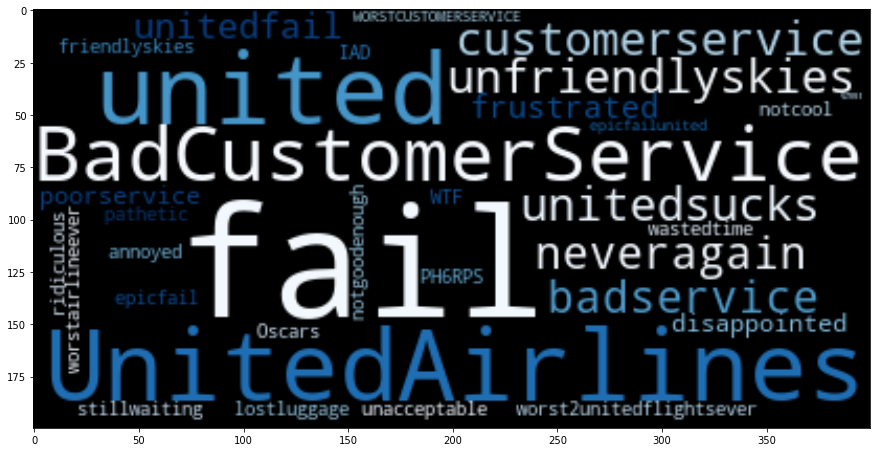

In [27]:
# United

wordcloud = WordCloud(colormap = 'Blues').generate(united_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

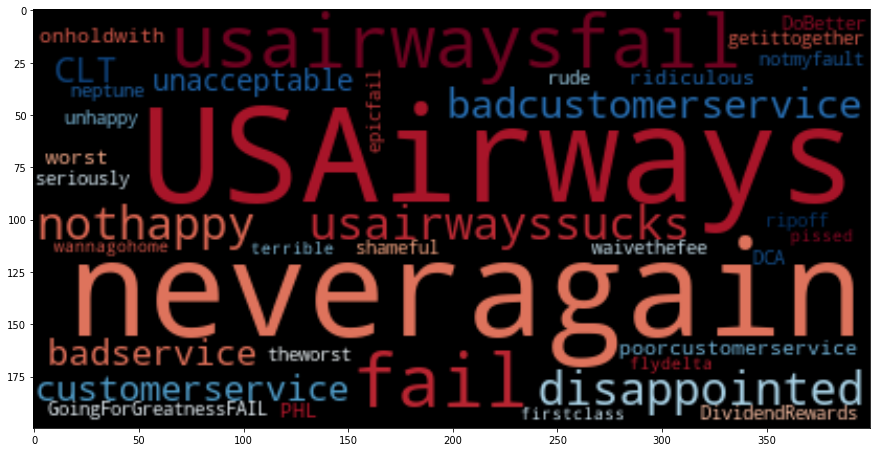

In [29]:
# US Airways

wordcloud = WordCloud(colormap = 'RdBu').generate(usair_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

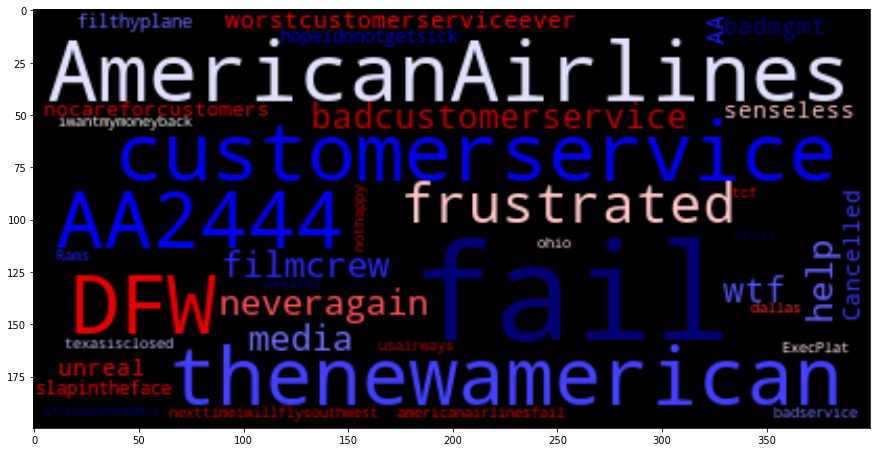

In [30]:
# American Airlines

wordcloud = WordCloud(colormap = 'seismic').generate(amer_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

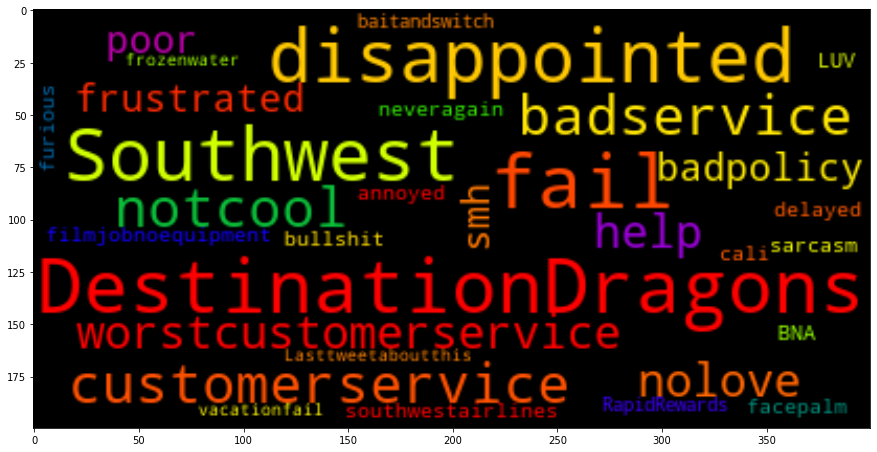

In [31]:
# Southwest

wordcloud = WordCloud(colormap = 'prism').generate(south_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

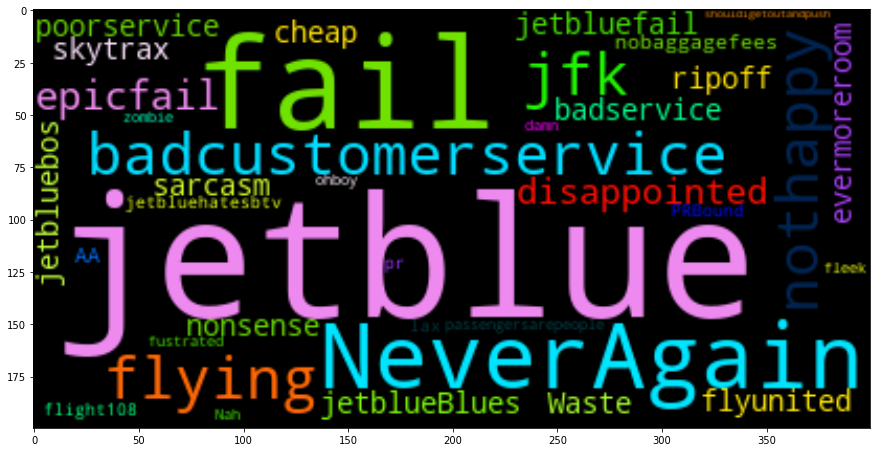

In [32]:
# Delta

wordcloud = WordCloud(colormap = 'gist_ncar').generate(delta_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

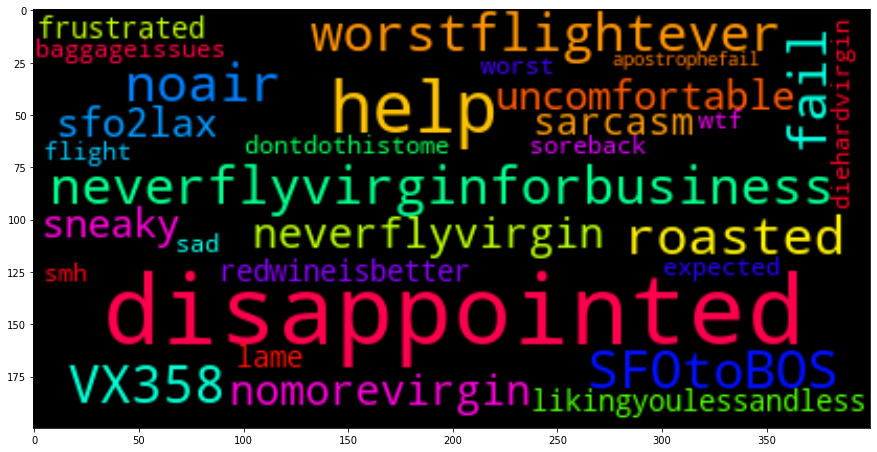

In [33]:
# Virgin

wordcloud = WordCloud(colormap = 'hsv').generate(virgin_string)

plt.figure(figsize =(15,8))
plt.imshow(wordcloud, interpolation='bilinear');

For the final step, we will go back to the full dataset of tweets, remove any @ handles, then build a simple classifier to assess if a tweet is positive, negative or neutral, based on its content. 

The reason for removing the @ handles is that, for example, @United might have more negative tweets than @Virgin, and so the classifier will associate United tweets with more negativity than Virgin tweets.

A similar implementation could be done as above, for removing the hashtags, but it was found that accuracy reduced on the model. It seems that hashtags are useful in predicting whether a tweet has a negative, positive or neutral sentiment.

In [40]:
df = df[['airline_sentiment', 'text']] # original tweets and sentiment

In [42]:
# function to remove all @ handles

handles = [] # empty list of handles

for i in np.arange(0, len(df)):
    handles.append(re.findall(r'@+[\w]+', df['text'][i]))
    # find any @ + alphanumeric, append to list
    
    for j in np.arange( 0, len(handles[i])):
           df['text'][i] = df['text'][i].replace(handles[i][j], '')
            # replace all @ + alphanumeric in tweet with ''

We have removed all @ handles. Now we can split the data and build the model.

In [43]:
X = df['text']
y = df['airline_sentiment']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)

In [59]:
# Build a pipeline and a linear support vector classifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_classifier = Pipeline([('tfidf', TfidfVectorizer()),
                             ('classifier', LinearSVC())]);

text_classifier.fit(X_train, y_train);

In [47]:
predictions = text_classifier.predict(X_test)

Below we have evaluation metrics for the model. 

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(confusion_matrix(y_test, predictions))

[[2563  179   72]
 [ 333  482   69]
 [ 137   87  470]]


In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      2814
     neutral       0.64      0.55      0.59       884
    positive       0.77      0.68      0.72       694

    accuracy                           0.80      4392
   macro avg       0.75      0.71      0.73      4392
weighted avg       0.79      0.80      0.79      4392



In [49]:
print(accuracy_score(y_test, predictions))

0.8003187613843351


So we are getting an accuracy of 80% overall. We can see from the classification report above that the best accuracy is on negative tweets. This is a good outcome, as negative tweets can give insight into actionable business solutions in order to retain customers, maintain brand loyalty, give better service, and impact business profits. 

Further to the above work, a more in-depth analysis could be done into the issues mentioned in the tweets, not just the hashtags, and from there solutions could be implemented. Then a further analysis of future tweets could be done, to see if there was a drop in the mention of such problems, e.g. the San Francisco to Boston or LAX flights. 

We could also use the prediction model to catch negative tweets as soon as they come, and get to work on fixing customer issues as soon as possible. All of this combined would help greatly with customer sentiment and customer service, which was a big problem for many airlines, as we saw illustrated above. 

One final thing is to check how our model could predict new tweets as they come in:

In [50]:
text_classifier.predict(["Thanks guys! We had a great flight!"])

array(['positive'], dtype=object)

In [60]:
text_classifier.predict(["Honestly, what a terrible flight. Delayed, bad service, and not a smile in sight!"])

array(['negative'], dtype=object)

Thanks for reading! :)